In [1]:
import pandas as pd
from functools import reduce
import numpy as np
import scipy.stats as stats # correlation analysis
import os
from sklearn import linear_model # regression analysis
from sklearn.linear_model import LogisticRegression # predictive modeling
from sklearn.model_selection import cross_val_predict # predictive modeling
from sklearn.model_selection import cross_val_score # predictive modeling
from sklearn.model_selection import RepeatedKFold # predictive modeling
import matplotlib.pyplot as plt # plotting
from matplotlib.offsetbox import OffsetImage, AnnotationBbox #plotting
import seaborn as sns;sns.set() # plotting
import doctest # testing

In [2]:
# Game results (collected from fightingillini.com, for testing hypotheses #1-3)
raw_results = pd.read_csv('Data\Game_Results.csv')
results =  pd.DataFrame(columns=['Illinois_pts', 'Opponents_pts', 'Point_difference', 'Result'])
results['Illinois_pts'] = raw_results['Score'].map(lambda x:x.split('-')[0]).astype('int')
results['Opponents_pts'] = raw_results['Score'].map(lambda x:x.split('-')[1]).astype('int')
results['Point_difference'] = results['Illinois_pts'] - results['Opponents_pts']
results['Result'] = raw_results['W/L'].str[0] 
results = results.replace({'W': 1.0, 'L': 0.0})
print(len(results))
results.head()

31


,Illinois_pts,Opponents_pts,Point_difference,Result
0,78,70,8,1.0
1,83,71,12,1.0
2,69,90,-21,0.0
3,66,53,13,1.0
4,85,57,28,1.0


In [3]:
# Concatenated game statistics by players (collected from fightingillini.com, for testing hypotheses #1-4)
rootdir = ('Data/Game Stats')
data_list = os.listdir(rootdir)
gamelist = []
for i in range(1,len(data_list)): # reading from 1, since 0 is "ipynb_checkpoints"
    path = os.path.join(rootdir, data_list[i])
    game = pd.read_csv(path)
    game['FGM'] = game['FG'].str.split('-').str[0].astype('int')
    game['FGA'] = game['FG'].str.split('-').str[1].astype('int')
    game['3PM'] = game['3PT'].str.split('-').str[0].astype('int')
    game['3PA'] = game['3PT'].str.split('-').str[1].astype('int')
    game['FTM'] = game['FT'].str.split('-').str[0].astype('int')
    game['FTA'] = game['FT'].str.split('-').str[1].astype('int')
    game['OREB'] = game['ORB-DRB'].str.split('-').str[0].astype('int')
    game['DREB'] = game['ORB-DRB'].str.split('-').str[1].astype('int')
    # Some aggregated statistics: "individual player efficiency" and "true shotting percentage"
    game['EFF'] = game['PTS']+game['REB']+game['A']+game['STL']+game['BLK']-game['TO']+game['FTM']-game['FTA']+game['FGM']-game['FGA']
    game['TS'] = game['PTS'] / (2 * game['FGA'] + 0.88 * game['FTA'])
    game['Match'] = i - 1 # add the nubmer of match (for further merging with "results" dataframe)
    game = game.drop(['FG', '3PT', 'FT', 'ORB-DRB'], axis = 1)
    gamelist.append(game)
games = pd.concat(gamelist).reset_index(drop=True) # concatenate all games
# unify player names
games.loc[games['Player'].str.contains(','), 'Player'] = games['Player'].str.split(',').str[1] + ' ' + games['Player'].str.split(',').str[0]
games.loc[games['Player'] == 'Ben Bosmans-Verdonk', 'Player'] = 'Benjamin Bosmans-Verdonk' 
print(len(games))
games.head()

344


,##,Player,GS,MIN,REB,PF,A,TO,BLK,STL,...,FGA,3PM,3PA,FTM,FTA,OREB,DREB,EFF,TS,Match
0,10,Andres Feliz,*,37,11,1,2,3,0,1,...,14,1,4,8,10,0,11,25,0.625000,0
1,11,Ayo Dosunmu,*,32,7,2,2,5,0,2,...,11,1,1,4,6,1,6,22,0.769795,0
2,15,Giorgi Bezhanishvili,*,34,4,3,0,4,0,0,...,9,2,2,1,3,3,1,4,0.532946,0
3,21,Kofi Cockburn,*,32,11,3,1,3,2,0,...,6,0,0,2,6,6,5,15,0.578704,0
4,01,Trent Frazier,*,35,4,1,4,1,0,1,...,9,0,6,4,4,0,4,3,0.185874,0


In [4]:
# Recruiting information of each player (including 3 newly-recruited players, collected from 247sports.com, for testing hypothesis #4)
recruit = pd.read_csv('Data\Recruit.csv')
print(len(recruit))
recruit.head()

17


,Player,Position,Rating,National Rank,Position Rank
0,Adam Miller,SG,0.9886,32.0,6.0
1,Andre Curbelo,PG,0.9835,43.0,8.0
2,Coleman Hawkins,PF,0.9217,152.0,35.0
3,Kofi Cockburn,C,0.9818,46.0,12.0
4,Benjamin Bosmans-Verdonk,PF,NaN,NaN,NaN


In [5]:
# Advanced statistics (collected from www.sports-reference.com, for testing hypothesis #4)
advanced_statistics = pd.read_csv('Data\Advanced_Statistics.csv')
print(len(advanced_statistics))
advanced_statistics.head()

14


,Player,G,GS,MP,PER,TS%,eFG%,3PAr,FTr,PProd,...,BLK%,TOV%,USG%,OWS,DWS,WS,WS/40,OBPM,DBPM,BPM
0,Kofi Cockburn,31,31,850,25.8,0.571,0.532,0.004,0.577,399,...,5.3,14.0,24.7,2.6,1.7,4.3,0.205,4.3,2.2,6.5
1,Ayo Dosunmu,30,30,1006,19.8,0.549,0.520,0.242,0.252,466,...,0.6,15.2,26.5,2.4,1.5,3.9,0.154,4.3,2.0,6.3
2,Andres Feliz,31,15,830,20.2,0.542,0.492,0.234,0.392,344,...,0.1,12.3,21.6,2.4,1.4,3.7,0.179,3.9,2.8,6.6
3,Alan Griffin,28,1,506,26.2,0.641,0.615,0.635,0.202,226,...,1.2,10.1,21.4,2.1,0.8,3.0,0.235,9.9,2.0,11.9
4,Trent Frazier,31,30,944,10.6,0.476,0.424,0.627,0.259,268,...,0.0,8.7,17.1,1.4,1.2,2.6,0.111,0.0,2.7,2.7


In [6]:
def correlation_analysis(df_game, df_result, statistics, filtering, threshold):
    """
    Correlation analysis of each player's certain statistics and the point difference of that game. This can be used to investigate close 
    games only (i.e. games with a point difference within certain threshold).
    
    :param df_game: a dataframe of the game statistics 
    :param df_result: a dataframe of the result statistics
    :param statistics: a string indicating the statistics to be test
    :param filtering: a boolean value indicating whether only the close games are kept 
    :param threshold: an integer value setting the threshold of the point difference for defining a "close game"
    :return: a series showing the correlation coefficient of each player's statistics adn the point difference of that game
    
    doctests to be added
    """
    games_and_results = pd.merge(df_game, df_result, left_on = 'Match', right_index = True)
    games_and_results = games_and_results[games_and_results['Player'] != 'TEAM']
    if filtering == True:
        games_and_results = games_and_results[games_and_results['Point_difference'].between(-threshold, threshold, inclusive = True)]
        games_and_results = games_and_results.groupby('Player').filter(lambda x: len(x) >= 3)
    coorrelation_result = games_and_results.groupby('Player')[[statistics, 'Point_difference']].corr().unstack().iloc[:,1]
    print(coorrelation_result.sort_values(ascending = False))
    result = coorrelation_result
    return result

## Testing hypotheses #1 and #2:

(1) Players' positive statistics (points, rebounds, assists, etc.) are positively related to the point differences in each game, while players' negative statistics (turnovers, fouls, etc.) are negative related to it.

(2) For the starting lineups and key players, the relationships in hypothesis 1 would be stronger in the close games (defined as |point difference| <=7).

In [7]:
# calculating the correlation of each player's "individual player efficiency" value and the point difference of that game: in all games, and 
# in close games only (games within 7 points difference)
full_eff_and_results = correlation_analysis(games, results, 'EFF', False, 0)
close_game_eff_and_results = correlation_analysis(games, results, 'EFF', True, 7)

Player
Zach Griffith               0.742801
Jermaine Hamlin             0.723792
Benjamin Bosmans-Verdonk    0.627500
Kofi Cockburn               0.617223
Tyler Underwood             0.587170
Da'Monte Williams           0.532452
Giorgi Bezhanishvili        0.495594
Andres Feliz                0.370754
Samson Oladimeji            0.327205
Trent Frazier               0.319636
Kipper Nichols              0.278551
Ayo Dosunmu                 0.252000
Alan Griffin                0.225900
Tevian Jones                0.024166
Name: (EFF, Point_difference), dtype: float64
Player
Ayo Dosunmu             0.427520
Kofi Cockburn           0.358946
Da'Monte Williams       0.182452
Andres Feliz            0.093749
Kipper Nichols          0.076044
Giorgi Bezhanishvili    0.055359
Alan Griffin           -0.036026
Trent Frazier          -0.127350
Tevian Jones           -0.422890
Jermaine Hamlin        -0.555556
Name: (EFF, Point_difference), dtype: float64


In [8]:
def plot_with_image(x, y, player_list, ylimmin, ylimmax, xlabel, ylabel, title, with_line, slope, intercept):
    """
    Creating a scatterplot with images of the players. A fitted regression line can also be added.
    
    :param x: a list showing the data in x axis
    :param y: a list showing the data in y axis
    :param player_list: a list of the player names (for finding the correponding images to display)
    :param ylimmin: a float value setting the minimum value of the y axis
    :param ylimmax: a float value setting the maximum value of the y axis
    :param xlabel: a string setting the label of the x axis
    :param ylabel: a string setting the label of the y axis
    :param title: a string setting the label of the title
    :param with_line: a boolean value indicating whether a line needs to be added in the scatterplot
    :param slope: a float value setting the slope of the line
    :param intercept: a float value setting the intercept of the line
    :return:
    
    doctests to be added
    """
    fig, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(x, y)
    if with_line == True:
        line_plot(slope, intercept, 0.82, 1, 1000, ax)
    plt.ylim(ylimmin, ylimmax)
    ax.set_xlabel(xlabel, fontsize = 25)
    ax.set_ylabel(ylabel, fontsize = 25)
    ax.set_title(title, fontsize = 25)
    image_annotate(x, y, player_list, ax)

In [9]:
def image_annotate(x, y, player_list, ax):
    """
    Adding the images on the plot.
    
    :param x: a list showing the data in x axis
    :param y: a list showing the data in y axis
    :param player_list: a list of the player names (for finding the correponding images to display)
    :param ax: the subplot object passed from the plot_with_image function
    :return: 
    
    doctests to be added
    """
    image_path = []
    for i in range(len(player_list)):
        path = 'Images/' + player_list[i] + '.png'
        image_path.append(path)
    for x0, y0, path in zip(x, y, image_path):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

In [10]:
def getImage(path):
    """
    Getting the path of an image.
    
    :param path: the directory of the image
    :return: offsetted image
    
    doctests to be added
    """
    return OffsetImage(plt.imread(path))

In [11]:
def line_plot(slope, intercept, x_start, x_end, x_pace, ax):
    """
    :param slope: a float value setting the slope of the line
    :param intercept: a float value setting the intercept of the line
    :param x_start: a float value setting the starting x value of the line
    :param x_end: a float value setting the starting ending x value of the line
    :param x_pace: an integer value setting the pace of the line between the starting x value and ending x value
    :param ax: the subplot object passed from the plot_with_image function
    :return:
    
    doctests to be added
    """
    line_x = np.linspace(x_start, x_end, x_pace)
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, color="teal", linewidth=2) 

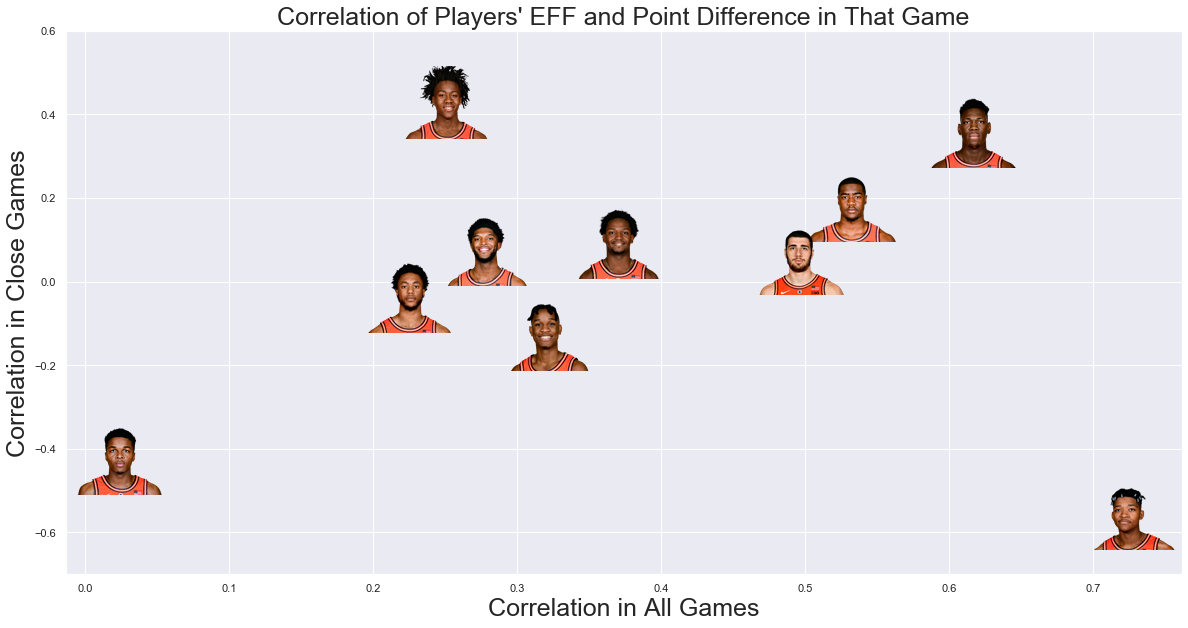

In [12]:
# visualization of the correlation of each player's "individual player efficiency" value and the point difference of that game (x axis 
# represents correlation in all games, and y axis represents correlation in close games within 7 points difference only)
full_and_close_game_eff_cor = pd.merge(full_eff_and_results, close_game_eff_and_results, left_index = True, right_index = True)
full_and_close_game_eff_cor.columns = ['correlation_full', 'correlation_close_games']
player_list_eff_correlation = full_and_close_game_eff_cor.index.tolist()
full_eff_cor_list = full_and_close_game_eff_cor['correlation_full'].tolist()
close_eff_cor_list = full_and_close_game_eff_cor['correlation_close_games'].tolist()
plot_with_image(full_eff_cor_list, close_eff_cor_list, player_list_eff_correlation, -0.7, 0.6, 'Correlation in All Games',
                'Correlation in Close Games', 'Correlation of Players\' EFF and Point Difference in That Game', False, 0, 0)

In [13]:
# calculating the correlation of each player's "true shooting percentage" value and the point difference of that game: in all games, and 
# in close games only (games within 7 points difference)
full_ts_and_results = correlation_analysis(games, results, 'TS', False, 0)
close_game_ts_and_results = correlation_analysis(games, results, 'TS', True, 7)

Player
Samson Oladimeji            1.000000
Jermaine Hamlin             0.855064
Tyler Underwood             0.739037
Benjamin Bosmans-Verdonk    0.674368
Zach Griffith               0.541663
Kofi Cockburn               0.432184
Andres Feliz                0.405754
Ayo Dosunmu                 0.310724
Trent Frazier               0.300779
Giorgi Bezhanishvili        0.222160
Alan Griffin                0.194104
Kipper Nichols              0.183937
Da'Monte Williams           0.130351
Tevian Jones               -0.026195
Name: (TS, Point_difference), dtype: float64
Player
Andres Feliz            0.204133
Kipper Nichols          0.184688
Alan Griffin            0.156383
Kofi Cockburn           0.104634
Ayo Dosunmu             0.071448
Giorgi Bezhanishvili   -0.109199
Trent Frazier          -0.164360
Da'Monte Williams      -0.350153
Tevian Jones           -1.000000
Jermaine Hamlin              NaN
Name: (TS, Point_difference), dtype: float64


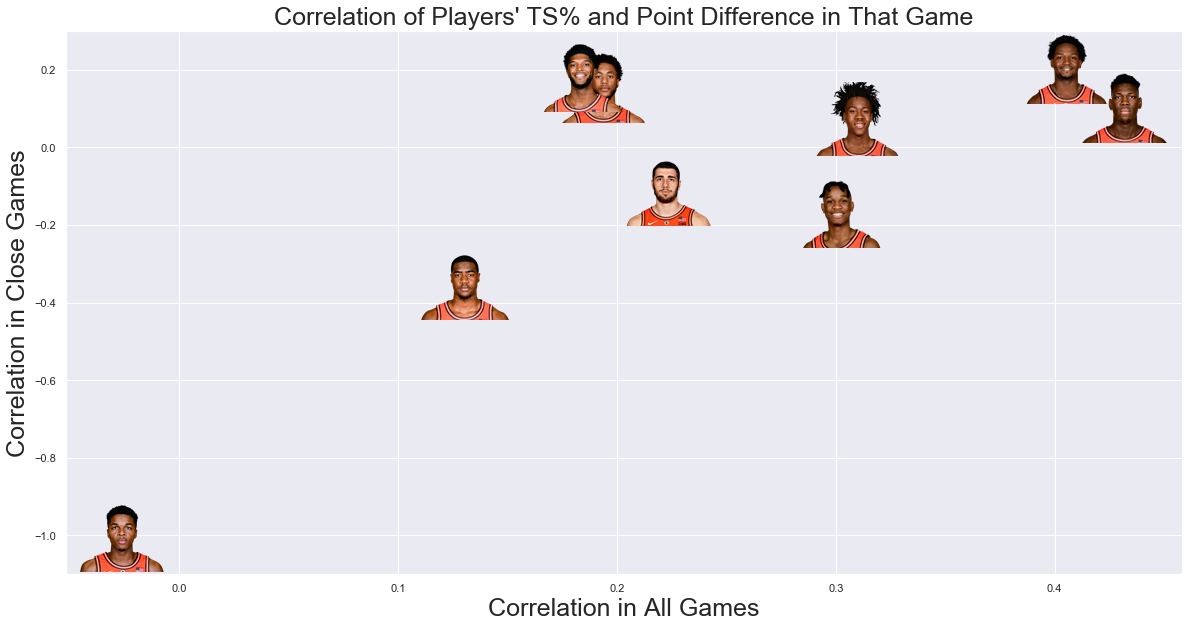

In [14]:
# visualization of the correlation of each player's "true shooting percentage" value and the point difference of that game (x axis 
# represents correlation in all games, and y axis represents correlation in close games within 7 points difference only)
full_and_close_game_ts_cor = pd.merge(full_ts_and_results, close_game_ts_and_results, left_index = True, right_index = True)
full_and_close_game_ts_cor.columns = ['correlation_full', 'correlation_close_games']
player_list_ts_correlation = full_and_close_game_ts_cor.index.tolist()
full_ts_cor_list = full_and_close_game_ts_cor['correlation_full'].tolist()
close_ts_cor_list = full_and_close_game_ts_cor['correlation_close_games'].tolist()
plot_with_image(full_ts_cor_list, close_ts_cor_list, player_list_ts_correlation, -1.1, 0.3, 'Correlation in All Games', 
                'Correlation in Close Games', 'Correlation of Players\' TS% and Point Difference in That Game', False, 0, 0)

In [15]:
# calculating the correlation of each player's points and the point difference of that game: in all games, and in close games only (games 
# within 7 points difference)
x=correlation_analysis(games, results, 'PTS', False, 0)
x=correlation_analysis(games, results, 'PTS', True, 7)

Player
Zach Griffith               0.822180
Jermaine Hamlin             0.741517
Tyler Underwood             0.651034
Benjamin Bosmans-Verdonk    0.577452
Kofi Cockburn               0.526478
Samson Oladimeji            0.438836
Giorgi Bezhanishvili        0.393116
Da'Monte Williams           0.388237
Alan Griffin                0.238579
Andres Feliz                0.177681
Trent Frazier               0.132084
Ayo Dosunmu                 0.097675
Kipper Nichols              0.086405
Tevian Jones               -0.107461
Name: (PTS, Point_difference), dtype: float64
Player
Ayo Dosunmu             0.395022
Giorgi Bezhanishvili    0.092484
Kofi Cockburn           0.087099
Kipper Nichols          0.025120
Andres Feliz           -0.012695
Tevian Jones           -0.037037
Da'Monte Williams      -0.074037
Trent Frazier          -0.090938
Alan Griffin           -0.129475
Jermaine Hamlin              NaN
Name: (PTS, Point_difference), dtype: float64


In [16]:
# calculating the correlation of each player's rebounds and the point difference of that game: in all games, and in close games only (games 
# within 7 points difference)
x=correlation_analysis(games, results, 'REB', False, 0)
x=correlation_analysis(games, results, 'REB', True, 7)

Player
Jermaine Hamlin             0.757357
Zach Griffith               0.700780
Benjamin Bosmans-Verdonk    0.630380
Tyler Underwood             0.495102
Kofi Cockburn               0.374308
Da'Monte Williams           0.345090
Samson Oladimeji            0.321584
Giorgi Bezhanishvili        0.146205
Kipper Nichols              0.115502
Tevian Jones                0.028960
Alan Griffin               -0.048296
Trent Frazier              -0.076017
Andres Feliz               -0.200770
Ayo Dosunmu                -0.219151
Name: (REB, Point_difference), dtype: float64
Player
Kofi Cockburn           0.404208
Andres Feliz            0.243500
Ayo Dosunmu             0.238857
Trent Frazier           0.212942
Giorgi Bezhanishvili   -0.075837
Da'Monte Williams      -0.100583
Kipper Nichols         -0.179460
Alan Griffin           -0.221793
Tevian Jones           -0.522233
Jermaine Hamlin        -0.555556
Name: (REB, Point_difference), dtype: float64


In [17]:
# calculating the correlation of each player's assists and the point difference of that game: in all games, and in close games only (games 
# within 7 points difference)
x=correlation_analysis(games, results, 'A', False, 0)
x=correlation_analysis(games, results, 'A', True, 7)

Player
Benjamin Bosmans-Verdonk    0.723046
Andres Feliz                0.627222
Jermaine Hamlin             0.494115
Zach Griffith               0.441077
Giorgi Bezhanishvili        0.333968
Kipper Nichols              0.298368
Trent Frazier               0.290480
Da'Monte Williams           0.270721
Tyler Underwood             0.238919
Kofi Cockburn               0.204449
Alan Griffin                0.117260
Ayo Dosunmu                 0.076373
Tevian Jones               -0.448310
Samson Oladimeji                 NaN
Name: (A, Point_difference), dtype: float64
Player
Da'Monte Williams       0.382763
Andres Feliz            0.271562
Ayo Dosunmu             0.248793
Kipper Nichols          0.162477
Trent Frazier           0.134551
Alan Griffin           -0.137473
Kofi Cockburn          -0.239813
Giorgi Bezhanishvili   -0.435248
Jermaine Hamlin              NaN
Tevian Jones                 NaN
Name: (A, Point_difference), dtype: float64


In [18]:
# calculating the correlation of each player's steals and the point difference of that game: in all games, and in close games only (games 
# within 7 points difference)
x=correlation_analysis(games, results, 'STL', False, 0)
x=correlation_analysis(games, results, 'STL', True, 7)

Player
Benjamin Bosmans-Verdonk    0.764888
Ayo Dosunmu                 0.287953
Da'Monte Williams           0.264622
Andres Feliz                0.251408
Jermaine Hamlin             0.236759
Kipper Nichols              0.224735
Kofi Cockburn               0.083428
Alan Griffin                0.011088
Giorgi Bezhanishvili       -0.044495
Trent Frazier              -0.103782
Samson Oladimeji                 NaN
Tevian Jones                     NaN
Tyler Underwood                  NaN
Zach Griffith                    NaN
Name: (STL, Point_difference), dtype: float64
Player
Kipper Nichols          0.309311
Giorgi Bezhanishvili    0.309311
Andres Feliz           -0.015434
Alan Griffin           -0.040771
Kofi Cockburn          -0.119199
Ayo Dosunmu            -0.119551
Da'Monte Williams      -0.466433
Jermaine Hamlin        -0.555556
Trent Frazier          -0.606236
Tevian Jones                 NaN
Name: (STL, Point_difference), dtype: float64


In [19]:
# calculating the correlation of each player's blocks and the point difference of that game: in all games, and in close games only (games 
# within 7 points difference)
x=correlation_analysis(games, results, 'BLK', False, 0)
x=correlation_analysis(games, results, 'BLK', True, 7)

Player
Jermaine Hamlin             0.497411
Kipper Nichols              0.230419
Benjamin Bosmans-Verdonk    0.196517
Alan Griffin                0.172919
Samson Oladimeji            0.151598
Tevian Jones                0.138600
Kofi Cockburn               0.028141
Giorgi Bezhanishvili        0.018489
Da'Monte Williams          -0.128723
Ayo Dosunmu                -0.161530
Andres Feliz               -0.294640
Trent Frazier                    NaN
Tyler Underwood                  NaN
Zach Griffith                    NaN
Name: (BLK, Point_difference), dtype: float64
Player
Da'Monte Williams       0.414384
Kofi Cockburn           0.172947
Ayo Dosunmu            -0.045846
Alan Griffin           -0.153158
Giorgi Bezhanishvili   -0.253607
Andres Feliz                 NaN
Jermaine Hamlin              NaN
Kipper Nichols               NaN
Tevian Jones                 NaN
Trent Frazier                NaN
Name: (BLK, Point_difference), dtype: float64


In [20]:
# calculating the correlation of each player's field goal attempts and the point difference of that game: in all games, and in close games
# only (games within 7 points difference)
x=correlation_analysis(games, results, 'FGA', False, 0)
x=correlation_analysis(games, results, 'FGA', True, 7)

Player
Jermaine Hamlin             0.696768
Tyler Underwood             0.686244
Zach Griffith               0.654065
Benjamin Bosmans-Verdonk    0.546192
Samson Oladimeji            0.451185
Kofi Cockburn               0.370743
Alan Griffin                0.248811
Da'Monte Williams           0.230083
Kipper Nichols             -0.021037
Giorgi Bezhanishvili       -0.050408
Trent Frazier              -0.166343
Andres Feliz               -0.198700
Tevian Jones               -0.307454
Ayo Dosunmu                -0.314730
Name: (FGA, Point_difference), dtype: float64
Player
Kofi Cockburn           0.323447
Ayo Dosunmu             0.262344
Giorgi Bezhanishvili    0.190810
Tevian Jones            0.104757
Andres Feliz            0.082036
Trent Frazier           0.057887
Da'Monte Williams      -0.102683
Kipper Nichols         -0.141516
Alan Griffin           -0.242164
Jermaine Hamlin        -0.555556
Name: (FGA, Point_difference), dtype: float64


In [21]:
# calculating the correlation of each player's free throw attempts and the point difference of that game: in all games, and in close games
# only (games within 7 points difference)
x=correlation_analysis(games, results, 'FTA', False, 0)
x=correlation_analysis(games, results, 'FTA', True, 7)

Player
Benjamin Bosmans-Verdonk    0.581066
Jermaine Hamlin             0.566762
Tevian Jones                0.539163
Tyler Underwood             0.513386
Da'Monte Williams           0.457709
Andres Feliz                0.360097
Giorgi Bezhanishvili        0.317861
Zach Griffith               0.145585
Kofi Cockburn               0.008028
Ayo Dosunmu                -0.069743
Kipper Nichols             -0.072179
Trent Frazier              -0.170457
Alan Griffin               -0.511396
Samson Oladimeji                 NaN
Name: (FTA, Point_difference), dtype: float64
Player
Ayo Dosunmu             0.608186
Trent Frazier           0.058232
Kipper Nichols          0.050721
Andres Feliz           -0.030997
Giorgi Bezhanishvili   -0.061736
Kofi Cockburn          -0.256284
Da'Monte Williams      -0.272448
Alan Griffin           -0.344005
Jermaine Hamlin              NaN
Tevian Jones                 NaN
Name: (FTA, Point_difference), dtype: float64


In [22]:
# calculating the correlation of each player's turnovers and the point difference of that game: in all games, and in close games only (games 
# within 7 points difference)
x=correlation_analysis(games, results, 'TO', False, 0)
x=correlation_analysis(games, results, 'TO', True, 7)

Player
Jermaine Hamlin             0.426191
Benjamin Bosmans-Verdonk    0.364066
Tevian Jones                0.362021
Tyler Underwood             0.208086
Kipper Nichols              0.154149
Kofi Cockburn               0.100845
Trent Frazier               0.034348
Da'Monte Williams          -0.080031
Alan Griffin               -0.095828
Andres Feliz               -0.137114
Giorgi Bezhanishvili       -0.225583
Ayo Dosunmu                -0.245232
Samson Oladimeji                 NaN
Zach Griffith                    NaN
Name: (TO, Point_difference), dtype: float64
Player
Ayo Dosunmu             0.009169
Andres Feliz           -0.026732
Kipper Nichols         -0.166180
Kofi Cockburn          -0.207191
Trent Frazier          -0.313853
Alan Griffin           -0.526777
Da'Monte Williams      -0.573604
Giorgi Bezhanishvili   -0.705857
Jermaine Hamlin              NaN
Tevian Jones                 NaN
Name: (TO, Point_difference), dtype: float64


In [23]:
# calculating the correlation of each player's personal fouls and the point difference of that game: in all games, and in close games only 
# (games within 7 points difference)
x=correlation_analysis(games, results, 'PF', False, 0)
x=correlation_analysis(games, results, 'PF', True, 7)

Player
Benjamin Bosmans-Verdonk    0.552199
Jermaine Hamlin             0.500443
Tyler Underwood             0.031031
Ayo Dosunmu                -0.072168
Tevian Jones               -0.103992
Alan Griffin               -0.118395
Kofi Cockburn              -0.139310
Da'Monte Williams          -0.174902
Andres Feliz               -0.200454
Trent Frazier              -0.244150
Kipper Nichols             -0.302558
Giorgi Bezhanishvili       -0.476691
Samson Oladimeji                 NaN
Zach Griffith                    NaN
Name: (PF, Point_difference), dtype: float64
Player
Jermaine Hamlin         0.333333
Da'Monte Williams       0.144784
Andres Feliz            0.121758
Kofi Cockburn           0.033675
Kipper Nichols          0.021003
Tevian Jones           -0.037037
Alan Griffin           -0.205891
Trent Frazier          -0.381703
Giorgi Bezhanishvili   -0.467628
Ayo Dosunmu            -0.628241
Name: (PF, Point_difference), dtype: float64


## Testing hypothesis #3:

If we predictive model the game results with stats, by iteratively removing the player's stats that contribute least to the model accuracy in each round, the key players will be kept at last.

In [24]:
def get_predictive_model(df_games, df_results, player_list, statistics):
    """
    Generating the data used for predictive modeling the results, which contains both parameters for training and the keys (game results).
    
    :param df_games: dataframe of the game statistics 
    :param df_results: a dataframe of the result statistics
    :param player_list: a list of the player names
    :param statistics: a string indicating the statistics used in predictive modeling
    :return: a dataframe containing parameters for training (statistics of each player) and the keys (game results)
    
    doctests to be added
    """
    df_players = list(range(len(player_list)))
    for i in range(len(df_players)):
        df_players[i] = df_games.groupby('Player').get_group(player_list[i])
        df_players[i] = df_players[i].rename(columns={statistics: player_list[i]})
    df_merged = reduce(lambda left,right: pd.merge(left, right, on=['Match'], how='outer'), df_players)
    df_merged = df_merged.sort_values('Match').set_index('Match')
    df_output = pd.merge(df_merged[player_list], df_results, left_index=True, right_index=True)
    df_output.drop(columns=['Illinois_pts', 'Opponents_pts', 'Point_difference'], inplace=True)
    df_output = df_output.replace(np.nan, 0)
    return df_output

In [25]:
player_list_full = games['Player'].unique().tolist()
player_list_full.sort()
player_list_full.remove('TEAM')
predictive_model = get_predictive_model(games, results, player_list_full, 'EFF')

In [26]:
def predictive_modeling(model):
    """
    Predictive modeling the results based on players' statistics, and iteratively remove the player(s) that contribute(s) least to the
    accuarcy of the model.
    
    :param model: a dataframe of the model used for predictive modeling 
    :return: 
    
    doctests to be added
    """
    key = model['Result']
    parameter = model.drop(['Result'], axis=1)
    Regression = LogisticRegression(solver = 'lbfgs', max_iter = 10000)
    rkf = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 1)
    
    count = 1
    while True:
        prediction_dict = {}
        prediction_all = sum(cross_val_score(Regression, parameter, key, cv = rkf)) / 100
        for player in parameter.columns:
            parameter_new = parameter.drop([player], axis = 1)
            predictions = cross_val_score(Regression, parameter_new, key, cv = rkf)
            prediction_dict[player] =  prediction_all - sum(predictions) / 100
        least_predictive_player = min(prediction_dict, key = prediction_dict.get)
        predictive_player = []
        not_predictive_player = []
        for player in prediction_dict:
            if prediction_dict[player] == prediction_dict[least_predictive_player]:
                not_predictive_player.append(player)
            else:
                predictive_player.append(player)
        for player in not_predictive_player:
            print("In round {}, player {} is least effective in predicting game results and is removed from the model".format(count, player))
            parameter = parameter.drop([player], axis = 1)
        if len(predictive_player) <= 1:
            if len(predictive_player) == 1:
                for player in prediction_dict:
                    if prediction_dict[player] != prediction_dict[least_predictive_player]:
                        most_predictive_player = player
                print("Player {} is the most effective in predicting game results".format(most_predictive_player))
            break
        count += 1

In [27]:
# Predictive modeling the results based on player's "individual player efficiency" value, and show the player(s) being removed in each round
player_list_full = games['Player'].unique().tolist()
player_list_full.sort()
player_list_full.remove('TEAM')
predictive_model = get_predictive_model(games, results, player_list_full, 'EFF')
predictive_modeling(predictive_model)

In round 1, player Tevian Jones is least effective in predicting game results and is removed from the model
In round 2, player Jermaine Hamlin is least effective in predicting game results and is removed from the model
In round 3, player Kipper Nichols is least effective in predicting game results and is removed from the model
In round 4, player Benjamin Bosmans-Verdonk is least effective in predicting game results and is removed from the model
In round 4, player Samson Oladimeji is least effective in predicting game results and is removed from the model
In round 5, player Trent Frazier is least effective in predicting game results and is removed from the model
In round 5, player Tyler Underwood is least effective in predicting game results and is removed from the model
In round 5, player Zach Griffith is least effective in predicting game results and is removed from the model
In round 6, player Alan Griffin is least effective in predicting game results and is removed from the model
In

## Testing hypothesis #4:

(4) The performance of a player (measured by EFF (individual player efficiency) value and PER (player efficiency rating) value) is positively correlated to his recruiting rating at the point of commitment, which is based on his performance in high school.

In [28]:
def regression(x, y):
    """
    Regresion analysis of player's average value in certain statistics and their recruiting rating. The function is used to fit a line showing
    the correlation of these two varaibles.
    
    :param x: a series showing the x value in the regression
    :param y: a series showing the y value in the regression
    :return: a float value of the coefficient of the fitted regression line, and a float value of the intercept of the fitted regression line.
    
    doctests to be added
    """
    x = np.array(x)
    regr = linear_model.LinearRegression()
    regr.fit(x.reshape(-1,1), y)
    return regr.coef_, regr.intercept_

In [29]:
# calculating the slope and intercept of the fitted regression line, as well as the correlation coefficient and p value of player's mean 
# "individual player efficiency" value and their recruiting rating 
mean_eff = games.groupby('Player')['EFF'].mean()
recruit_and_statistics = pd.merge(recruit, mean_eff, on=['Player']).drop(['National Rank', 'Position Rank'], axis = 1)
recruit_and_statistics = recruit_and_statistics.dropna(axis=0).reset_index(drop=True)
eff_regress = regression(recruit_and_statistics['Rating'], recruit_and_statistics['EFF'])
eff_slope, eff_intercept = eff_regress[0], eff_regress[1]
eff_rating_cor = stats.pearsonr(recruit_and_statistics["EFF"],recruit_and_statistics["Rating"])
print("Pearson’s correlation coefficient is {:.2f}".format(eff_rating_cor[0]))
print("P value is {:.2f}".format(eff_rating_cor[1]))

Pearson’s correlation coefficient is 0.44
P value is 0.23


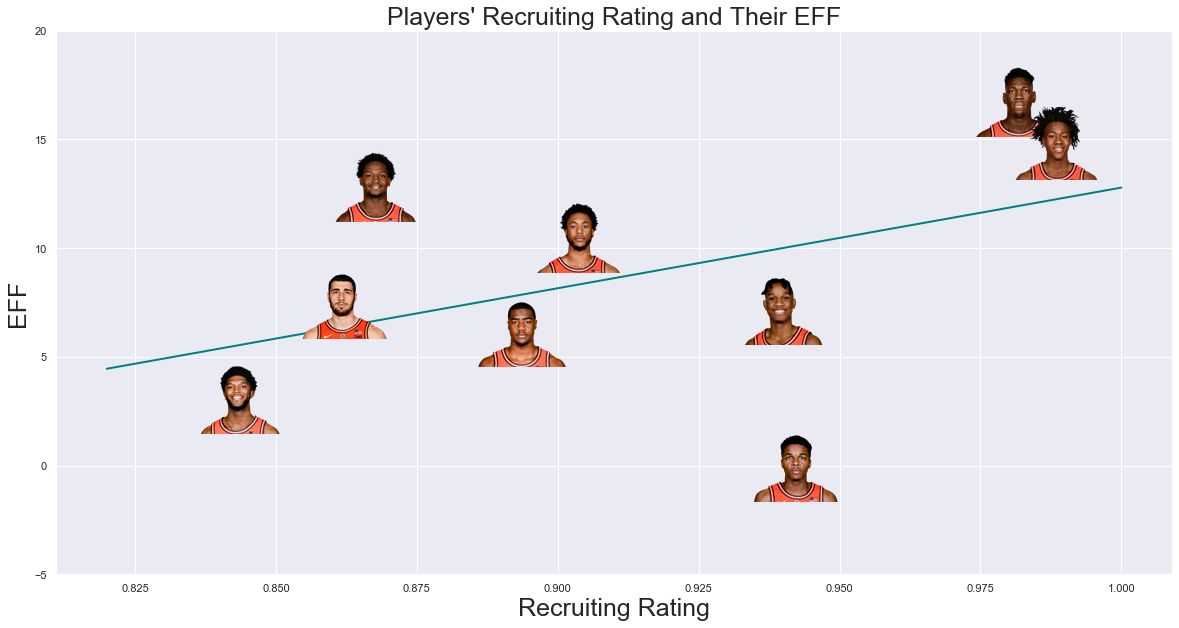

In [30]:
# visualization of the correlation of player's mean "individual player efficiency" value and their recruiting rating (with a fitted line)
player_list_rating = recruit_and_statistics['Player'].tolist()
eff_list = recruit_and_statistics['EFF'].tolist()
rating_list = recruit_and_statistics['Rating'].tolist()
plot_with_image(rating_list, eff_list, player_list_rating, -5, 20, 'Recruiting Rating', 'EFF', 'Players\' Recruiting Rating and Their EFF',
                True, eff_slope, eff_intercept)

In [31]:
def plot_with_rookies(x0, y0, list0, x_rookie, y_rookie, list_rookie, ylimmin, ylimmax, xlabel, ylabel, title, slope, intercept):
    """
    Creating a scatterplot with images of the players with a fitted regression line, including predicted value of the rookies.
    
    :param x0: a list showing the data in x axis (data of non-rookies)
    :param y0: a list showing the data in y axis (data of non-rookies)
    :param list0: a list of the player names (for finding the correponding images to display, data of non-rookies)
    :param x_rookie: a list showing the data in x axis (data of rookies)
    :param y_rookie: a list showing the data in y axis (data of rookies)
    :param list_rookie: a list of the player names (for finding the correponding images to display, data of rookies)
    :param ylimmin: a float value setting the minimum value of the y axis
    :param ylimmax: a float value setting the maximum value of the y axis
    :param xlabel: a string setting the label of the x axis
    :param ylabel: a string setting the label of the y axis
    :param title: a string setting the label of the title
    :param slope: a float value setting the slope of the line
    :param intercept: a float value setting the intercept of the line
    :return:
    
    doctests to be added
    """
    fig, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(x0, y0, marker='*', color='#E84A27', s=500)
    line_plot(slope, intercept, 0.82, 1, 1000, ax)
    plt.ylim(ylimmin, ylimmax)
    ax.set_xlabel(xlabel, fontsize = 25)
    ax.set_ylabel(ylabel, fontsize = 25)
    ax.set_title(title, fontsize = 25)
    for i in range(len(list0)):
        plt.annotate(list0[i], xy = (x0[i], y0[i]), xytext = (x0[i], y0[i] - ylimmax/20), fontsize=15)
        
    ax.scatter(x_rookie, y_rookie, marker='*', color='#13294B', s=500)
    for i in range(len(list_rookie)):
        if i != 1:
            plt.annotate(list_rookie[i], xy = (x_rookie[i], y_rookie[i]), 
                         xytext = (x_rookie[i], y_rookie[i] - ylimmax/20) ,fontsize=15)
        else:
            plt.annotate(rookie_list[i], xy = (x_rookie[i], y_rookie[i]), 
                         xytext = (x_rookie[i] - 0.015, y_rookie[i] + ylimmax/30), fontsize=15)

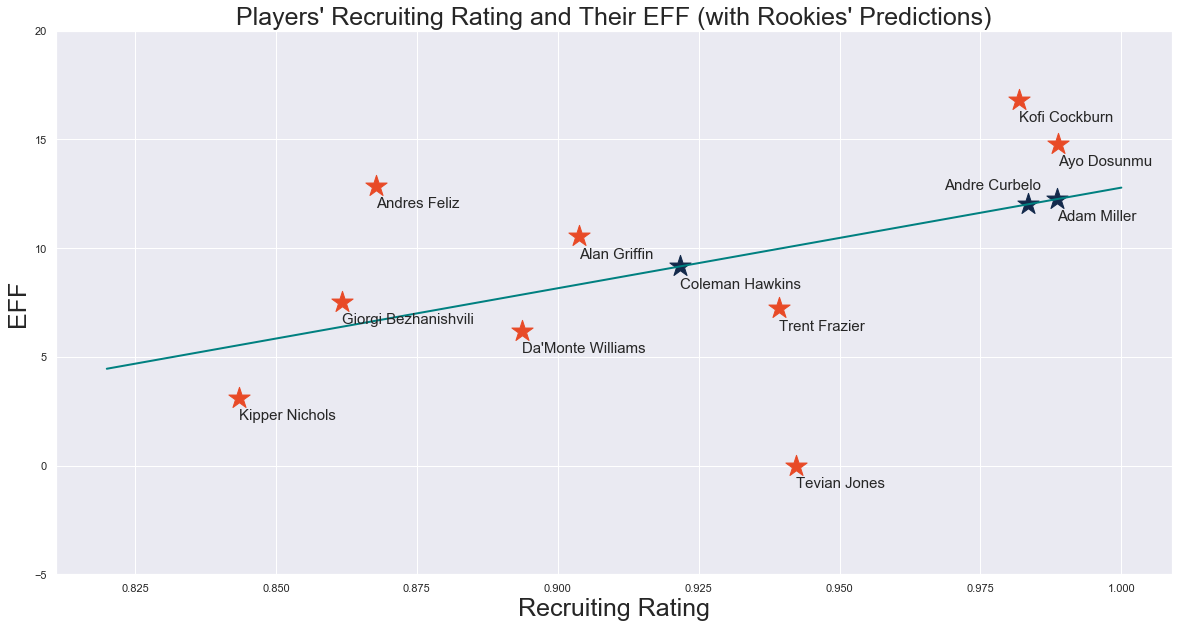

In [32]:
# visualization of the correlation of player's mean "individual player efficiency" value and their recruiting rating (with a fitted line),
# rookies are also included with their predicted "individual player efficiency" value based on their recruiting rating.
all_player_list = recruit['Player'].tolist()
non_rookie_list = advanced_statistics['Player'].tolist()
rookie_list = []
for player in all_player_list:
    if player not in non_rookie_list:
        rookie_list.append(player)
rookie_rating = recruit[recruit['Player'].isin(rookie_list)]['Rating'].tolist()
rookie_estimated_eff = [rating * eff_slope + eff_intercept for rating in rookie_rating]
plot_with_rookies(rating_list, eff_list, player_list_rating, rookie_rating, rookie_estimated_eff, rookie_list, -5, 20, 'Recruiting Rating', 
                  'EFF', 'Players\' Recruiting Rating and Their EFF (with Rookies\' Predictions)', eff_slope, eff_intercept)

In [33]:
# calculating the slope and intercept of the fitted regression line, as well as the correlation coefficient and p value of player's mean 
# "player efficiency rating" value and their recruiting rating 
recruit_and_advanced = pd.merge(recruit, advanced_statistics, on=['Player']).drop(['National Rank', 'Position Rank'], axis = 1)
recruit_and_advanced = recruit_and_advanced.dropna(axis=0).reset_index(drop=True)
per_regress = regression(recruit_and_advanced['Rating'], recruit_and_advanced['PER'])
per_slope, per_intercept = per_regress[0], per_regress[1]
per_rating_cor = stats.pearsonr(recruit_and_advanced["PER"],recruit_and_advanced["Rating"])
print("Pearson’s correlation coefficient is {:.2f}".format(per_rating_cor[0]))
print("P value is {:.2f}".format(per_rating_cor[1]))

Pearson’s correlation coefficient is 0.21
P value is 0.59


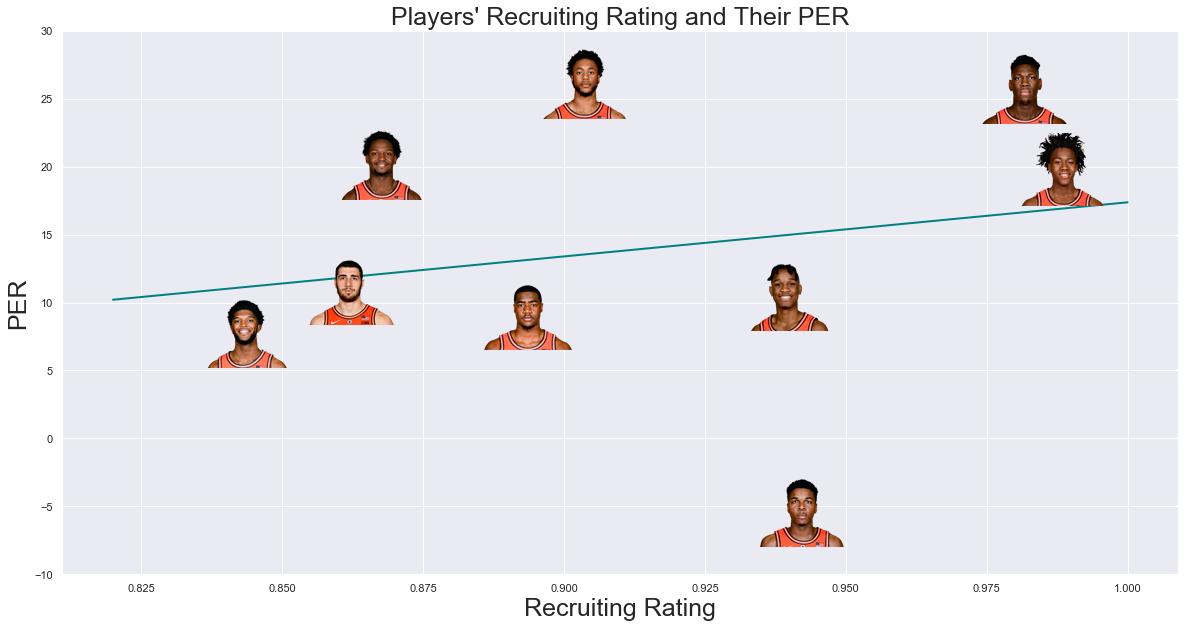

In [34]:
# visualization of the correlation of player's mean "player efficiency rating" value and their recruiting rating (with a fitted line)
per_list = recruit_and_advanced['PER'].tolist()
plot_with_image(rating_list, per_list, player_list_rating, -10, 30, 'Recruiting Rating', 'PER', 'Players\' Recruiting Rating and Their PER',
                True, per_slope, per_intercept)

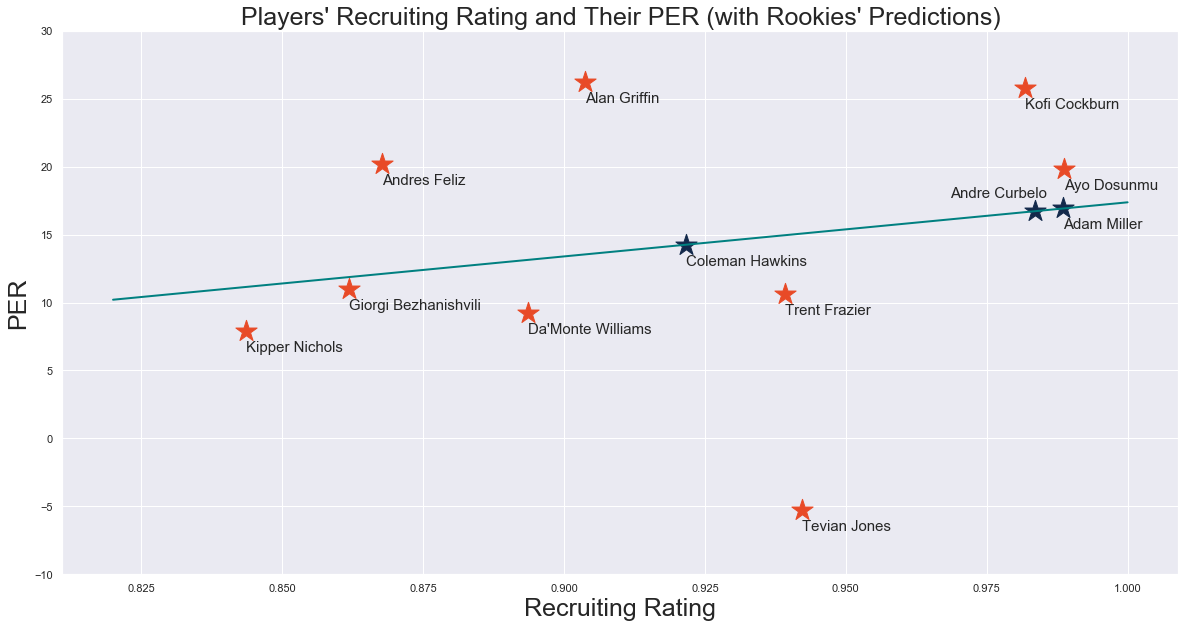

In [35]:
# visualization of the correlation of player's mean "player efficiency rating" value and their recruiting rating (with a fitted line),
# rookies are also included with their predicted "individual player efficiency" value based on their recruiting rating.
rookie_estimated_per = [rating * per_slope + per_intercept for rating in rookie_rating]
plot_with_rookies(rating_list, per_list, player_list_rating, rookie_rating, rookie_estimated_per, rookie_list,  -10, 30, 'Recruiting Rating', 
                  'PER', 'Players\' Recruiting Rating and Their PER (with Rookies\' Predictions)', per_slope, per_intercept,)

In [36]:
doctest.testmod(verbose=True)

10 items had no tests:
    __main__
    __main__.correlation_analysis
    __main__.getImage
    __main__.get_predictive_model
    __main__.image_annotate
    __main__.line_plot
    __main__.plot_with_image
    __main__.plot_with_rookies
    __main__.predictive_modeling
    __main__.regression
0 tests in 10 items.
0 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=0)